In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['mushrooms']


In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np 

import matplotlib.pyplot as plt
import time
import os


In [3]:
from fastai.callbacks import ActivationStats
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [4]:
#path = untar_data(URLs.MNIST_SAMPLE)
#data = ImageDataBunch.from_folder(path)
#learn = cnn_learner(data, models.resnet18, callback_fns=ActivationStats)
#learn = Learner(data, simple_cnn((3,16,16,2)), callback_fns=ActivationStats)
#learn.wd = 0.0001
#learn.fit(2)

#bs = 192
#xfit = np.linspace(0, bs-1,bs)
#mean_y = learn.activation_stats.stats[0][1][-(bs-1):]
#std_y = learn.activation_stats.stats[1][1][-(bs-1):]
# Visualize the result
#plt.plot(xfit, mean_y, '-', color='gray')

#plt.fill_between(xfit, mean_y - std_y, mean_y + std_y,
#                 color='gray', alpha=0.2)

In [5]:
class_names = os.listdir('../input/mushrooms/Mushrooms/')

In [6]:
bs = 64
path = Path("../input/mushrooms/Mushrooms/")
fnames = []
for fpath in class_names:
    print(path/f'{fpath}/')
    fnames += get_image_files(path/f'{fpath}/')

../input/mushrooms/Mushrooms/Hygrocybe
../input/mushrooms/Mushrooms/Lactarius
../input/mushrooms/Mushrooms/Agaricus
../input/mushrooms/Mushrooms/Suillus
../input/mushrooms/Mushrooms/Cortinarius
../input/mushrooms/Mushrooms/Amanita
../input/mushrooms/Mushrooms/Boletus
../input/mushrooms/Mushrooms/Russula
../input/mushrooms/Mushrooms/Entoloma


### load data and create test set

In [11]:
np.random.seed(2)
pat = r"/(\w+)/\d+(_).+\.jpg$"
data = ImageDataBunch.from_name_re('.', fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs, num_workers = 0).normalize(imagenet_stats)
train_dataset, test_dataset = torch.utils.data.random_split(data.train_ds, [len(data.train_ds) - 600, 600])


In [12]:
data = DataBunch.create(train_dataset.dataset, data.valid_ds, test_dataset.dataset, num_workers = 0)

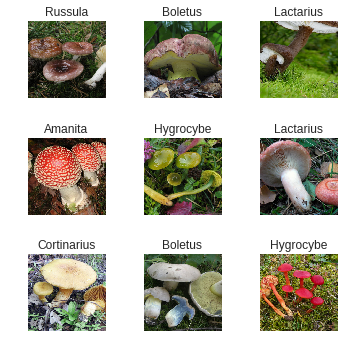

In [13]:
data.show_batch(rows=3, figsize=(5,5))

## Fix to load Truncated images

In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 61068319.65it/s]


In [16]:
learn.fit_one_cycle(4, max_lr = 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,1.240570,1.053303,0.651267,03:46
2,0.921867,0.748939,0.741431,03:36
3,0.705064,0.612050,0.790611,03:36
4,0.534372,0.464136,0.835320,03:37


In [17]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


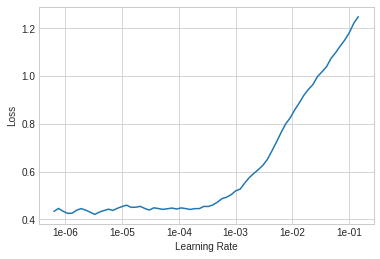

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,5e-4))

epoch,train_loss,valid_loss,accuracy,time
1,0.439963,0.446872,0.842027,03:36
2,0.364644,0.428127,0.853204,03:34


In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


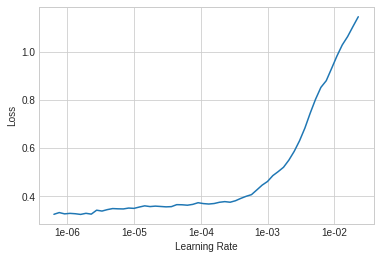

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,accuracy,time
1,0.351638,0.417736,0.858420,03:40
2,0.329149,0.411192,0.863636,03:38
3,0.322587,0.405737,0.865872,03:37
4,0.308104,0.393810,0.874814,03:40
5,0.299496,0.394641,0.871833,03:37


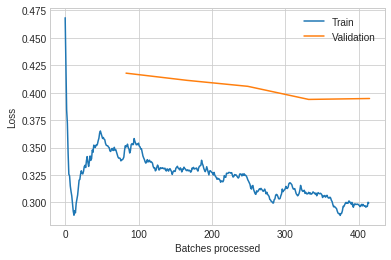

In [23]:
learn.recorder.plot_losses()

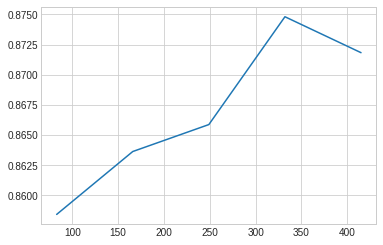

In [24]:
learn.recorder.plot_metrics()

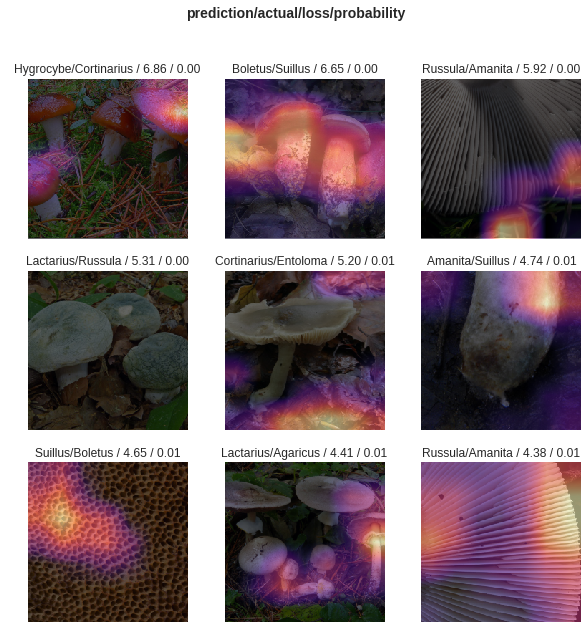

In [25]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(10,10))


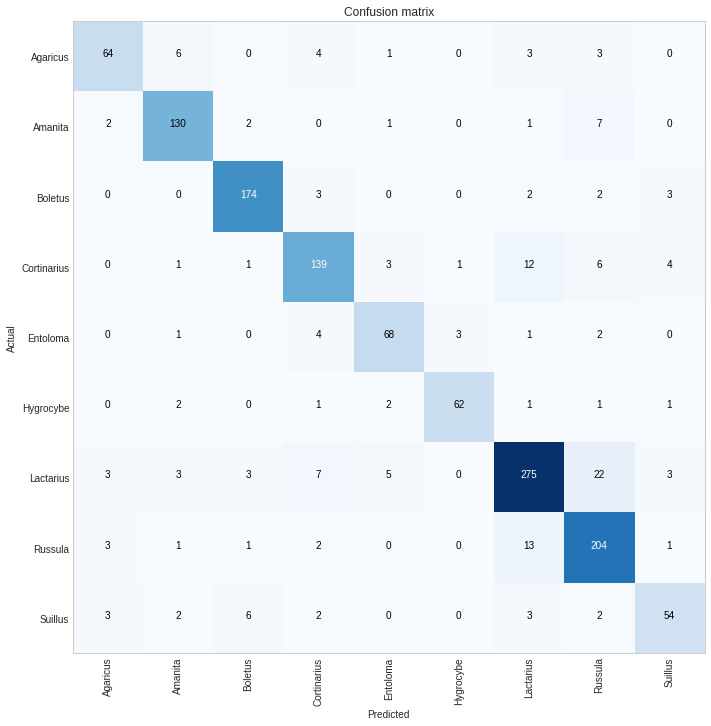

In [26]:
interp.plot_confusion_matrix(figsize=(10,10))


In [43]:
preds_test,y_test, losses_test= learn.get_preds(ds_type=data.test_ds, with_loss=True)

In [49]:
print("Accuracy on test set: ", accuracy(preds_test,y_test).item())

Accuracy on test set:  0.9547654390335083
